In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [123]:
df = pd.read_csv("Downloads/tedx_dataset.csv")
print(df.head)

<bound method NDFrame.head of                                    idx       main_speaker  \
0     8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1     b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2     4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3     59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4     d227f2faf6ec185e54436d86463f499b      Daniel Finkel   
...                                ...                ...   
4462  af5603a3fa28c9721c155b9f6f69c580       Hans Rosling   
4463  b89b3443794b2f415caa0acee1a12976   Sir Ken Robinson   
4464  f315fd9d7be4b5e27620f8e93562a028      Majora Carter   
4465  868caf84a7ef51349e63b37b64e4c2ca        David Pogue   
4466  94ded6639b0277d8f48ccaf5991417c3            Al Gore   

                                                  title  \
0                       The intangible effects of walls   
1     It's OK to feel overwhelmed. Here's what to do...   
2                                     "Accept Who I Am"   
3

In [125]:
df.shape


(4467, 7)

In [127]:
df.isnull().sum()

idx                0
main_speaker       1
title              0
details            0
posted             0
url                0
num_views       4258
dtype: int64

In [129]:
splitted = df['posted'].str.split(" ",expand=True)
#converting years colunm to integers and handling non - numeric values
splitted[2] = pd.to_numeric(splitted[2], errors='coerce')
splitted[2] = splitted[2].fillna(0).astype('int')
#creating a colunm for months and year
df['year'] = splitted[2]
df['month'] = splitted[1]

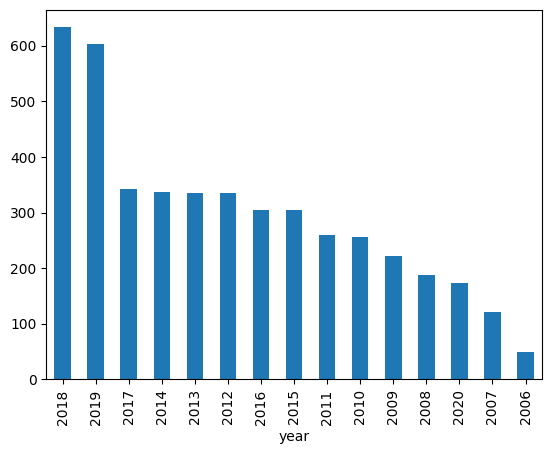

In [131]:
df['year'].value_counts().plot.bar()
plt.show()

In [133]:
#combine titles and detail 
df['details'] = df['title']+ '   ' +df['details']
#removing unnecessary inf
df=df[['main_speaker', 'details']]
df.dropna(inplace=True)
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barrier...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable ..."
3,Ethan Lisi,"What it's really like to have autism ""Autism..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accord...


In [135]:
data = df.copy()

In [137]:
# Assuming stopwords are already downloaded
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    imp_words = []
    for word in words:
        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)  # Fixed the join syntax
    return output

# Apply the function to the 'details' column
df['details'] = df['details'].apply(lambda text: remove_stopwords(text))
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects walls More barriers exi...
1,Elizabeth Gilbert,It's OK feel overwhelmed. Here's next If feeli...
2,Butterscotch,"""Accept Who I Am"" Firing formidable beatboxing..."
3,Ethan Lisi,"What really like autism ""Autism disease; anoth..."
4,Daniel Finkel,Can solve sea monster riddle? According legend...


In [139]:
punctuations_list = string.punctuation


def clean_punctuations(text):
    signal = str.maketrans('', '', punctuations_list)
    return text.translate(signal)


df['details'] = df['details'].apply(lambda x: clean_punctuations(x))
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects walls More barriers exi...
1,Elizabeth Gilbert,Its OK feel overwhelmed Heres next If feeling ...
2,Butterscotch,Accept Who I Am Firing formidable beatboxing s...
3,Ethan Lisi,What really like autism Autism disease another...
4,Daniel Finkel,Can solve sea monster riddle According legend ...


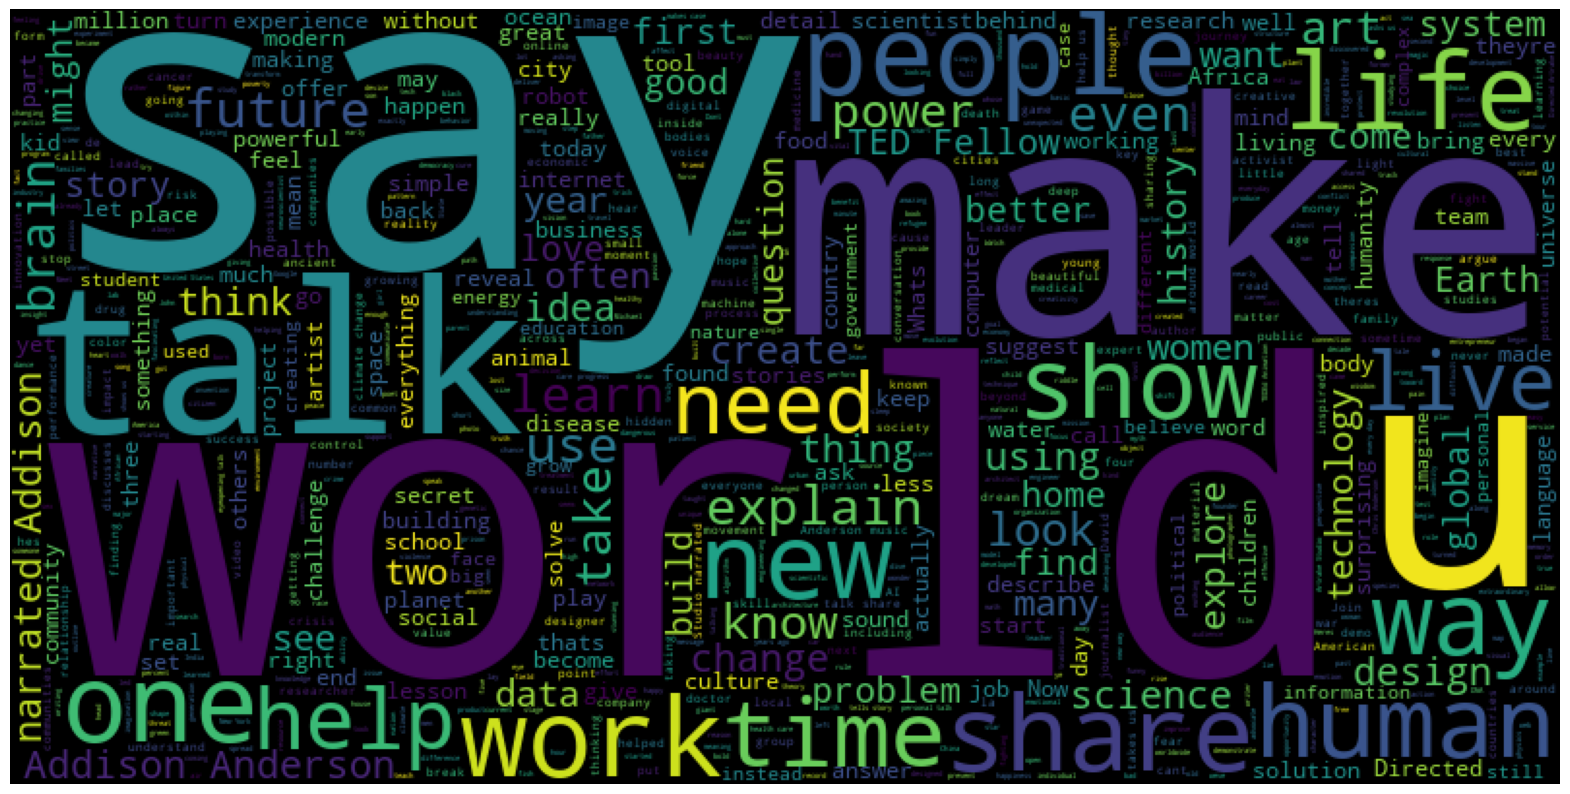

In [141]:
details_corpus = " ".join(df['details'])

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, 
               width=800,
               height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

In [142]:
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects walls More barriers exi...
1,Elizabeth Gilbert,Its OK feel overwhelmed Heres next If feeling ...
2,Butterscotch,Accept Who I Am Firing formidable beatboxing s...
3,Ethan Lisi,What really like autism Autism disease another...
4,Daniel Finkel,Can solve sea monster riddle According legend ...


In [145]:
%%capture
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['details'])

In [147]:
def get_similarities(talk_content, data=df):

    # Getting vector for the input talk_content.
    talk_array1 = vectorizer.transform(talk_content).toarray()

    # We will store similarity for each row of the dataset.
    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']

        # Getting vector for current talk.
        talk_array2 = vectorizer.transform(
            data[data['details'] == details]['details']).toarray()

        # Calculating cosine similarities
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]

        # Calculating pearson correlation
        pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]

        sim.append(cos_sim)
        pea.append(pea_sim)

    return sim, pea


In [149]:
def recommend_talks(talk_content, data=data):

    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)

    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
                     False, False], inplace=True)

    display(data[['main_speaker', 'details']].head())


In [151]:
talk_content = ['Time Management and working\
hard to become successful in life']
recommend_talks(talk_content)

,main_speaker,details
1758,Laura Vanderkam,How to gain control of your free time There ...
2173,Philip Krinks,Finding your personal mission in life Philip...
66,Fang Ruan,Management lessons from Chinese business and p...
1658,Chimamanda Ngozi Adichie,We should all be feminists We teach girls th...
4387,Seth Godin,How to get your ideas to spread In a world o...
